In [2]:
from wandb.keras import WandbCallback
import wandb
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow import convert_to_tensor
import numpy as np
from transformers import TFDistilBertModel
from extract_bert_features import embed, make_pipe
from model_k import create_model
from scipy.spatial.distance import cosine
from tensorflow.keras.callbacks import EarlyStopping
from progress.bar import Bar
import pandas as pd

from timer import timer

import matplotlib.pyplot as plt

from spacyNER import create_training_data_per_entity_spacy


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# IMPORT import df from file


In [1]:
import pandas as pd
from data import get_training_data

# train_x/y has only the embeddings
train_x, test_x, train_y, test_y = get_training_data(
    save_dir="results",
    radius=10,
    fraction=0.99,
    count=-1,
    force_recreate=True,
    entity_filter=['PER','ORG','LOC'])


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'create_training_data_per_entity_fewNERD' from 'fewNERD_data' (c:\Users\Will\Projects\MSc\project\fewNERD_data.py)

In [16]:
# plot loss
# summarize history for loss
def plot_loss(history) -> None:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('validation')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


grid search

In [17]:
default = {
    "ae": [
        {"n": 768, "act": "relu"},
        {"n": 500, "act": "relu"},
        {"n": 2000, "act": "relu"},
    ],
    "repr": [
        {"n": 2000, "act": "relu"},
        {"n": 768, "act": "relu"},
        {"n": 768, "act": "relu"},
    ],
    "latent": {"n": 160, "act": "relu"},
    "output": "sigmoid",
    "opt": "adam",
    "loss": "mse",
    "lr": 0.001,
    "batch": 256
}

grid = [
    # big
    {
        "name": "4 deep big - 160 latent",
        **default,

        "output": "tanh",
    },
    # sigmoid
    # {
    #     "name": "1 deep - 160 latent",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    # },
    # {
    #     "name": "2 deep - 160 latent",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 400, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    # },
    # {
    #     "name": "3 deep - 160 latent",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 512, "act": "relu"},
    #         {"n": 256, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    # },
    # tanh
    # {
    #     "name": "1 deep - 160 latent - tanh",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    #     "output": "tanh",
    # },
    # {
    #     "name": "2 deep - 160 latent - tanh",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 400, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    #     "output": "tanh",
    # },
    # {
    #     "name": "3 deep - 160 latent - tanh",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 512, "act": "relu"},
    #         {"n": 256, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    #     "output": "tanh",
    # },


]


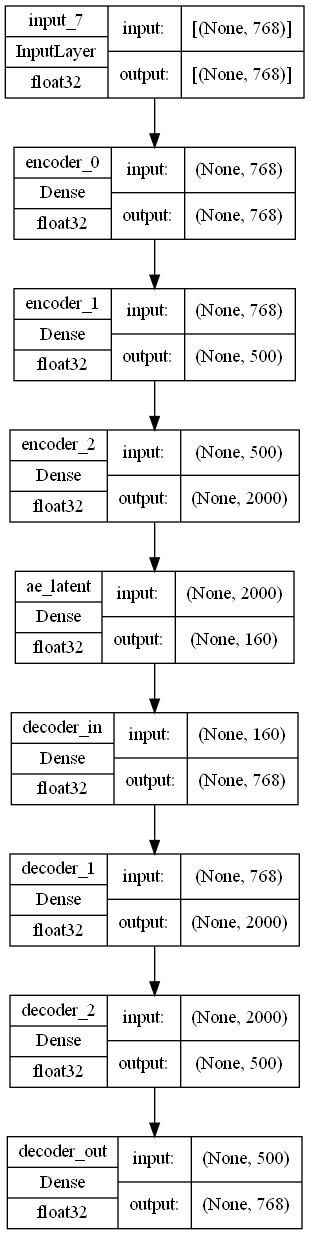

In [18]:
model = create_model(grid[0])
plot_model(model, show_dtype=True, 
            show_layer_names=True, show_shapes=True)

Full df: (3895, 771)
Train df: (3116, 768)
Test df: (779, 768)
Training 4 deep big - 160 latent
Epoch 34: early stopping
...Loss => 6.633363246917725


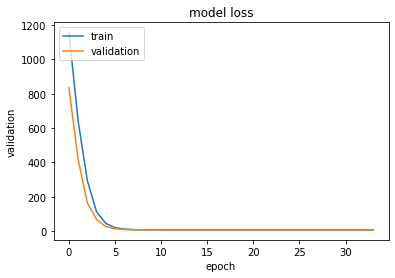

In [19]:

early_stopping_cb = EarlyStopping(
    monitor='loss', patience=15, verbose=1, min_delta=0.0001)

for config in grid:
    train_x, test_x = test_train_split()
    model = create_model(config)
    print(f"Training {config['name']}")
    plot_model(model, show_dtype=True, 
                       show_layer_names=True, show_shapes=True)
    history = model.fit(
        train_x,
        train_x,
        validation_data=(test_x, test_x),
        epochs=2000,
        batch_size=config["batch"],
        shuffle=True,
        verbose=0,
        callbacks=[early_stopping_cb],
    )
    print(f"...Loss => {history.history['loss'][-1]}")
    plot_loss(history)

In [ ]:
# find best latent dims
early_stopping_cb = EarlyStopping(
    monitor='loss', patience=10, verbose=1, min_delta=0.00001)

best_loss = {"dims": 0, "loss": 100}
test_dims = [16, 32, 48, 64, 96, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 256, 512, 768]
# test_dims = range(140, 180, 1)
# test_dims = [168]
test_batches = [1024]
test_history = []
for latent_dim in test_dims:
    for batch_size in test_batches:
        model = create_model(
            layers=[
                {"n": 768, "act": "relu"},
                # {"n": 512, "act": "relu"},
                # {"n": 256, "act": "relu"},
            ],
            latent_layer={"n": latent_dim, "act": "relu"},
            output_fn="tanh",
            optimizer_fn="adam",
            loss_fn="mse",
            verbose=0)
        print(f"Training {latent_dim} latent dims, batch: {batch_size}")
        history = model.fit(
            train_x,
            train_x,
            validation_data=(test_x, test_x),
            epochs=2000,
            batch_size=1024,
            validation_split=0.1,
            shuffle=True,
            verbose=0,
            callbacks=[early_stopping_cb],
        )
        loss = history.history['val_loss'][-1]
        print(f"...Loss => {loss}")
        test_history.append(loss)
        if loss < best_loss["loss"]:
            best_loss = {
                "dims": latent_dim, "loss": loss, "batch_size": batch_size}

# results
plt.plot(test_dims, test_history)
plt.title('autoencoder loss vs latent dims')
plt.ylabel('loss')
plt.xlabel('dimensions')
plt.show()
print(
    f"Best latent dims: {best_loss['dims']}, "
    f"batch:{best_loss['batch_size']} => {best_loss['loss']}")

# DEC approach

In [1]:
import os
import numpy as np
from keras.initializers import VarianceScaling
from tensorflow.keras.optimizers import SGD
from DEC import DEC
from metrics import acc
from data import get_training_data

entity_types=['PER','ORG','LOC', 'MISC']

save_dir = "./results"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# load dataset
dataset = "conll"
if dataset == "reuters":
    from datasets_deep import load_reuters
    x, y = load_reuters()
else:
    x, test_x, y, test_y = get_training_data(save_dir="results",
                                             count=10000,
                                             source="fewNERD",
                                             radius=5,
                                             fraction=0.99,
                                             entity_filter=entity_types,
                                             force_recreate=False)
x.shape

c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Making pipe
Finished 'make_pipe' in 5.915 secs
Create Training Data for 10000 items, radius 5


Reusing dataset few-nerd (C:\Users\Will\.cache\huggingface\datasets\DFKI-SLT___few-nerd\supervised\0.0.0\e1ceeaee82073fea12206e4461c7cfcd67e68c8f3ebeca179bddcacee00c4511)
100%|██████████| 3/3 [00:00<00:00, 333.23it/s]


Dataset loaded


100%|██████████| 9999/9999 [00:00<00:00, 142845.43it/s]


Dataset processed
Created NER Data for 8590 items


22903it [28:38, 13.33it/s]                         


Created 17351 training items


100%|██████████| 17351/17351 [00:00<00:00, 40730.01it/s]


Finished 'create_training_data_per_entity_fewNERD' in 1729.82 secs
Created entries: 17351
(17351, 772)
Saved results\training_data_radius_fewNERD_5.csv
Full df: (17351, 772)
Train df: (17177, 768)
Test df: (174, 768)


(17177, 768)

In [2]:
def train_DEC(x, y):
    print(f"{dataset} dataset: {x.shape} x:{type(x)}, y:{type(y)}")
    assert(len(np.unique(y)) <= len(entity_types))
    n_clusters = len(np.unique(y))
    print(f"{n_clusters} clusters")

    init = 'glorot_uniform'
    pretrain_optimizer = 'adam'
    # setting parameters

    pretrain_epochs = 50
    init = VarianceScaling(scale=1. / 3., mode='fan_in',
                        distribution='uniform')  # [-limit, limit], limit=sqrt(1./fan_in)
    pretrain_optimizer = SGD(learning_rate=1, momentum=0.9)

    # prepare the DEC model
    dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, init=init)

    if os.path.exists(os.path.join(save_dir, 'ae_weights.h5')):
        print("Loading weights")
        dec.autoencoder.load_weights(os.path.join(save_dir, 'ae_weights.h5'))
    else:
        print("Training weights")
        dec.pretrain(x=x, y=y, optimizer=pretrain_optimizer,
                        epochs=pretrain_epochs, batch_size=256,
                        save_dir='./results')

    dec.model.summary()
    dec.compile(optimizer=SGD(0.01, 0.9), loss='kld')

    return dec

dec = train_DEC(x, y)

conll dataset: (17177, 768) x:<class 'numpy.ndarray'>, y:<class 'numpy.ndarray'>
4 clusters
Loading weights
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               384500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 clustering (ClusteringLayer  (None, 4)                40        
 )                 

In [3]:
%%timeit 
update_interval = 30
y_pred = dec.fit(x, y=y, tol=0.001, maxiter=2e4, batch_size=256,
    update_interval=update_interval, save_dir=save_dir)
print('acc:', acc(y, y_pred))


Update interval 30
Save interval 335
Initializing cluster centers with k-means.
537/537 [==============================] - 0s 802us/step
Iter 0: acc = 0.31030, nmi = 0.01565, ari = 0.00231  ; loss= 0
saving model to: ./results/DEC_model_0.h5
Iter 30: acc = 0.30651, nmi = 0.01564, ari = 0.00154  ; loss= 0.01136
Iter 60: acc = 0.30419, nmi = 0.01495, ari = 0.00049  ; loss= 0.0163
Iter 90: acc = 0.29918, nmi = 0.01420, ari = 0.00065  ; loss= 0.02167
Iter 120: acc = 0.30215, nmi = 0.01410, ari = 0.00054  ; loss= 0.03342
Iter 150: acc = 0.30745, nmi = 0.01439, ari = 0.00086  ; loss= 0.04639
Iter 180: acc = 0.31205, nmi = 0.01335, ari = 0.00121  ; loss= 0.06171
Iter 210: acc = 0.31397, nmi = 0.01245, ari = 0.00256  ; loss= 0.06847
Iter 240: acc = 0.31402, nmi = 0.01258, ari = 0.00248  ; loss= 0.07918
Iter 270: acc = 0.31565, nmi = 0.01235, ari = 0.00407  ; loss= 0.08662
Iter 300: acc = 0.31577, nmi = 0.01234, ari = 0.00392  ; loss= 0.09278
Iter 330: acc = 0.31478, nmi = 0.01252, ari = 0.0047


# fewNERD data

In [1]:
import numpy as np
from timer import timer
from fewNERD_data import create_training_data_per_entity_fewNERD


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training_data = create_training_data_per_entity_fewNERD(length=50, radius=10, entity_filter=[1,2,3,4])
print("Training data created")

Making pipe
Finished 'make_pipe' in 7.092 secs
Create Training Data for 50 items, radius 10


Reusing dataset few-nerd (C:\Users\Will\.cache\huggingface\datasets\DFKI-SLT___few-nerd\supervised\0.0.0\e1ceeaee82073fea12206e4461c7cfcd67e68c8f3ebeca179bddcacee00c4511)
100%|██████████| 3/3 [00:00<00:00, 374.83it/s]


Dataset loaded


100%|██████████| 49/49 [00:00<00:00, 48968.52it/s]


Dataset processed
Created NER Data for 49 items


134it [00:05, 24.38it/s]                       

Created 53 training items
Finished 'create_training_data_per_entity_fewNERD' in 20.531 secs
Training data created
